# Research about sparse regression for vb by Latent vairable
## Background
+ In this study, we show how variable selection by latent variable gives a model selection.
    + Especially, we consider about linear regression case.
    
+ To update the result, we utilized a stochastic gradeient descent for vb

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.stats import wishart, norm
from scipy.special import gammaln, digamma, logsumexp
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

# problem settings

In [3]:
data_seed = 20210626
n = 100
M = 100

N = 100

In [4]:
true_p = 0.2

In [5]:
np.random.seed(data_seed)

In [6]:
true_w = np.random.normal(size=M, scale=3)
zero_ind = np.sort(np.random.dirichlet(np.ones(M), size=1).squeeze().argsort()[:np.floor(true_p * M).astype(int)])
true_w[zero_ind] = 0

In [7]:
# X_base = np.random.uniform(-1, 1, size=n)
# train_X = X_base[:,np.newaxis]**(np.arange(M)[np.newaxis,:])
# train_X = np.random.uniform(-1,1, size=(n, M))
original_train_X = np.random.normal(size=(n, M))
original_train_Y = original_train_X@true_w + np.random.normal(scale=0.1, size=n)

In [25]:
# X_base = np.random.uniform(-1, 1, size=N)
# test_X = X_base[:,np.newaxis]**(np.arange(M)[np.newaxis,:])
original_test_X = np.random.uniform(-1,1, size=(N, M))
original_test_Y = original_X@true_w + np.random.normal(scale=1, size=N)

In [8]:
true_w

array([ 0.4294891 , -1.40978187, -2.84652443,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  0.        ,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698, -3.16340453,  1.04157394,
        6.12070258, -4.54728625,  1.80098301,  1.25293761, -0.50114129,
       -0.36065756, -6.0292734 , -1.94586965, -0.95279392,  0.        ,
       -7.99746874,  6.10961841, -1.02320217,  1.31086624,  2.2902942 ,
        0.        , -2.40232506,  2.97325466,  0.        ,  7.48580323,
        0.        , -1.39259302, -9.59472893,  3.97642022,  3.26153344,
        0.        ,  2.08410259, -4.49926818, -3.10226697, -2.65354347,
        1.36337223,  0.        , -1.64682997, -1.06526825, -2.92123115,
       -2.23117948,  1.47115227,  0.        , -1.28262698, -2.12500214,
       -1.14323844,  3.56325569,  1.23902351,  1.97769386,  0.        ,
       -3.3005887 , -1.46646434,  2.8132868 ,  4.10957732, -3.62366988,
       -2.07222035, -1.46284763, -4.59360551, -3.18941287, -0.15

## Common used functions

In [9]:
def _positive_sigmoid(x):
    return 1 / (1 + np.exp(-x))


def _negative_sigmoid(x):
    # Cache exp so you won't have to calculate it twice
    exp = np.exp(x)
    return exp / (exp + 1)


def sigmoid(x):
    positive = x >= 0
    # Boolean array inversion is faster than another comparison
    negative = ~positive

    # empty contains juke hence will be faster to allocate than zeros
    result = np.empty_like(x)
    result[positive] = _positive_sigmoid(x[positive])
    result[negative] = _negative_sigmoid(x[negative])

    return result

safe_log_odds = lambda x: np.log(np.clip(x, 1e-300, 1-1e-15)) - np.log(1-np.clip(x, 1e-300, 1-1e-15))

In [8]:
np.corrcoef(train_X.T, train_Y)[-1,:]

array([ 0.00729666, -0.04706821, -0.00526145, -0.10653619,  0.16465422,
       -0.08408611,  0.27382881, -0.01733269,  0.84899674, -0.33581773,
        1.        ])

In [9]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565])

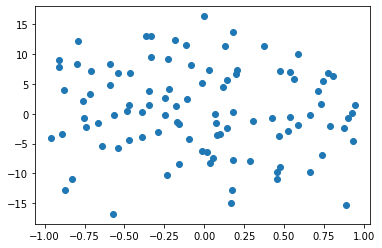

In [9]:
plt.scatter(test_X[:,1], test_Y)

# Learning part

## learning settings


In [66]:
pri_alpha = 6
pri_beta = 5
pri_gamma = 0.0001

iteration = 1
rho = 1
learning_seed = 20210717

tol = 1e-5

step = 100

## initialization

In [13]:
np.random.seed(learning_seed)

## main learning

In [14]:
def calc_energy(
    train_X: np.ndarray, train_Y: np.ndarray,
    est_alpha: float, est_beta: float, est_mu: np.ndarray, est_sigma: np.ndarray, 
    est_h_xi: np.ndarray, est_z_xi: np.ndarray,
    pri_alpha: float, pri_beta: float, pri_gamma: float, pri_delta_c: float=0.001
):
    (n, M) = train_X.shape
    
    sum_alpha_beta = est_alpha+est_beta
    eta_p1 = digamma(est_alpha)-digamma(est_alpha+est_beta)
    eta_p2 = digamma(est_beta)-digamma(est_alpha+est_beta)
    eta_m2 = np.outer(est_mu, est_mu) + est_sigma
    
    current_h_xi = np.vstack([
        eta_p1+log_normal_func(np.diag(eta_m2), pri_delta_c),
        eta_p2+log_normal_func(np.diag(eta_m2), 1/pri_gamma)
    ]).T
    
    KL_p = (est_alpha-1)*(eta_p1)+(est_beta-1)*(eta_p2)-(pri_alpha-1)*eta_p1-(pri_beta-1)*eta_p2\
    +gammaln(est_alpha+est_beta)-gammaln(est_alpha)-gammaln(est_beta)-gammaln(pri_alpha+pri_beta)+gammaln(pri_alpha)+gammaln(pri_beta)
    
    KL_m = -0.5*M-0.5*M*np.log(2*np.pi)+0.5*np.linalg.slogdet(est_sigma)[1]\
    - (logsumexp(est_h_xi).sum() + (est_z_xi * (current_h_xi - est_h_xi)).sum())
    
    loss_Y = 0.5*n*np.log(2*np.pi) + 0.5*((train_Y-train_X@est_mu)**2).sum() + 0.5*np.trace(train_X.T@train_X@est_sigma)
    
    return (KL_p+KL_m+loss_Y), KL_p, KL_m, loss_Y

In [15]:
def _transform_origin2natural(
    est_alpha: np.ndarray, est_beta: np.ndarray, est_mu: np.ndarray, est_sigma: np.ndarray
) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    transform parameter of posterior distribution from original space to natural parameter space on exponential family
    
    + Output:
        1. theta_p1
        2. theta_p2
        3. theta_m1
        4. theta_m2
    """
    return (est_alpha-1, est_beta-1, np.linalg.solve(est_sigma, est_mu), -np.linalg.inv(est_sigma)/2)

def _transform_original2expectation(
    est_alpha: np.ndarray, est_beta: np.ndarray, est_mu: np.ndarray, est_sigma: np.ndarray
) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    transform parameter of posterior distribution from natural parameter space to expectation parameter space on exponential family
    
    + Output:
        1. eta_p1: E[log p]
        2. eta_p2: E[log (1-p)]
        3. eta_m1: E[x]
        4. eta_m2: E[xx^T]
    """
    return(
        digamma(est_alpha) - digamma(est_alpha+est_beta), 
        digamma(est_beta) - digamma(est_alpha+est_beta),
        est_mu,
        est_sigma+np.outer(est_mu, est_mu)    
    )

def _transform_natural2origin(
    theta_p1: np.ndarray, theta_p2: np.ndarray, theta_m1: np.ndarray, theta_m2: np.ndarray
) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    transform parameter of posterior distribution from natural parameter space on exponential family to original space
    
    + Output:
        1. est_alpha
        2. est_beta
        3. est_mu
        4. est_sigma    
    """
    est_sigma = -0.5*np.linalg.inv(theta_m2)
    return(theta_p1+1, theta_p2+1, est_sigma@theta_m1, est_sigma)

In [16]:
def _calc_dFdeta(
    train_X: np.ndarray, train_Y: np.ndarray,
    theta_p1: np.ndarray, theta_p2: np.ndarray, theta_m1: np.ndarray, theta_m2: np.ndarray,
    est_z_xi: np.ndarray,
    pri_alpha: float, pri_beta: float, pri_gamma: float, pri_delta_c_t: float,
) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    Derivative of objective function F by expectation parameters
    
    + Output:
        1. Derivative of eta_p1
        2. Derivative of eta_p2
        3. Derivative of eta_m1
        4. Derivative of eta_m2
    """
    
    return (
        theta_p1 - est_z_xi[:,0].sum() - (pri_alpha - 1),
        theta_p2 - est_z_xi[:,1].sum() - (pri_beta - 1),
        theta_m1 - train_X.T@train_Y,
        theta_m2 + 0.5*train_X.T@train_X + (np.diag(est_z_xi[:,0]))/(2*pri_delta_c_t) + pri_gamma*(np.diag(est_z_xi[:,1]))/2,
    )

def _update_natural(
    theta_p1: np.ndarray, theta_p2: np.ndarray, theta_m1: np.ndarray, theta_m2: np.ndarray,
    dFdeta_p1: np.ndarray, dFdeta_p2: np.ndarray, dFdeta_m1: np.ndarray, dFdeta_m2: np.ndarray,
    rho_t: float
):
    return(
        theta_p1 - rho_t*dFdeta_p1,
        theta_p2 - rho_t*dFdeta_p2,
        theta_m1 - rho_t*dFdeta_m1,        
        theta_m2- rho_t*dFdeta_m2,
    )

In [18]:
est_alpha=M*np.random.uniform(size=1).squeeze()+pri_alpha
est_beta=M-(est_alpha-pri_alpha)+pri_beta
est_sigma = np.random.uniform(size=M).squeeze()
est_mu = np.random.normal(scale=2, size=M)
est_lambda = np.clip(0.5+np.random.normal(scale=0.01, size=M), 0, 1)

In [28]:
cov_X = train_X.T@train_X
cov_XY = train_Y@train_X

for ite in range(1):
    # transform to natural parameters
    theta_u1 = est_alpha-1
    theta_u2 = est_beta-1
    theta_z = safe_log_odds(est_lambda)
    theta_w1 = est_mu/est_sigma
    theta_w2 = -1/est_sigma/2

    # tranform to expectation parameters
    eta_u1 = digamma(est_alpha) - digamma(est_alpha+est_beta)
    eta_u2 = digamma(est_beta) - digamma(est_alpha+est_beta)
    eta_w1 = est_mu
    eta_z = est_lambda
    eta_w2 = est_mu**2+est_sigma

    # derivate of expectation parameters
    dFdeta_u1 = theta_u1-eta_z.sum()-(pri_alpha-1)
    dFdeta_u2 = theta_u2-(1-eta_z).sum()-(pri_beta-1)
    dFdeta_z = theta_z-(cov_XY*eta_w1)\
    +((cov_X-np.diag(np.diag(cov_X)))*np.outer(eta_w1, eta_w1))@eta_z\
    +np.diag(cov_X)*eta_w2/2-eta_u1+eta_u2
    
    dFdeta_w1 = theta_w1-(cov_XY*eta_z)
    dFdeta_w2 = theta_w2+np.diag(cov_X)*eta_z/2+pri_gamma/2

    # update global parameters
    rho_t=rho/(ite+1)
    theta_u1 -= rho_t*dFdeta_u1
    theta_u2 -= rho_t*dFdeta_u2
    theta_z -= rho_t*dFdeta_z
    theta_w1 -= rho_t*dFdeta_w1
    theta_w2 -= rho_t*dFdeta_w2

    # transoform to original parameters
    est_alpha=theta_u1+1
    est_beta=theta_u2+1
    est_lambda=sigmoid(theta_z)
    est_sigma=-1/theta_w2/2
    est_mu=est_sigma*theta_w1
    
    print(dFdeta_u1**2, dFdeta_u2**2, (dFdeta_z**2).sum(), (dFdeta_w1**2).sum(), (dFdeta_w2**2).sum())

2.399780289409693 2.399780289409693 1974304.7396120098 152319.05235020886 2497.7016045393466


In [61]:
(cov_XY*est_mu)

array([2.82785850e+00, 7.08504578e+00, 6.96914609e+00, 1.70428166e+03,
       3.96410889e+02, 4.51199170e+02, 3.16851171e+02, 3.17868783e+01,
       5.10882762e+03, 4.12527931e+02])

In [62]:
np.diag(cov_X)*(est_mu**2+est_sigma**2)/2

array([1.47247636e+00, 3.49337095e+00, 3.51735361e+00, 8.42486650e+02,
       1.93917922e+02, 2.25301815e+02, 1.57191596e+02, 1.58575631e+01,
       2.51459889e+03, 2.03235802e+02])

In [65]:
((cov_X-np.diag(np.diag(cov_X)))*np.outer(est_mu, est_mu))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [63]:
((cov_X-np.diag(np.diag(cov_X)))*np.outer(est_mu, est_mu))@eta_z

array([  4.00775417,  -8.52668724,   1.86957044, -15.95349434,
        -1.47205406,  17.20416608,   6.03012019,  28.64015246,
       -78.53641126, -82.72141362])

In [33]:
dFdeta_z

array([  -4.03240191,  -11.49651719,   -1.6731704 ,  -27.52932713,
         -3.55079285,  -13.4203375 ,  -10.31242309,   -4.10169771,
       -128.54639598,  -29.94072254])

In [67]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565])

In [27]:
est_lambda_dbg = est_lambda.copy()
dFdeta_dbg = est_lambda.copy()

In [29]:
for j in range(M):
    dFdeta_dbg[j] = safe_log_odds(est_lambda[j]) - (
        (cov_XY*est_mu)\
        -((cov_X-np.diag(np.diag(cov_X)))*np.outer(est_mu, est_mu))@est_lambda_dbg\
        -np.diag(cov_X)*(est_mu**2+est_sigma**2)/2\
        +digamma(est_alpha)-digamma(est_beta)
    )[j]
    est_lambda_dbg[j] = sigmoid(
        (cov_XY*est_mu)\
        -((cov_X-np.diag(np.diag(cov_X)))*np.outer(est_mu, est_mu))@est_lambda_dbg\
        -np.diag(cov_X)*(est_mu**2+est_sigma**2)/2\
        +digamma(est_alpha)-digamma(est_beta)
    )[j]
    pass

In [24]:
cov_XY

array([ 193.9332676 , -392.1303394 ,  135.43091963,  985.85510403,
        245.78380691, -490.23368201,  474.27162105,  245.77884519,
       1525.56569775, -870.7360595 ])

In [25]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565])

In [28]:
train_X.mean(axis=0)

array([ 0.06513529, -0.02310443, -0.00578348, -0.00654022,  0.0252471 ,
        0.00811808,  0.05910662, -0.00678073, -0.04176428,  0.01923225])

In [27]:
train_X.std(axis=0)

array([0.93562946, 1.00517333, 0.9889158 , 0.8932258 , 0.91253051,
       1.05125936, 1.01391087, 0.99990848, 1.00749444, 1.06819978])

In [30]:
est_lambda_dbg

array([0.98269629, 0.99999026, 0.84819848, 1.        , 0.97210206,
       0.99999863, 0.99996768, 0.98351078, 1.        , 1.        ])

In [32]:
dFdeta_dbg

array([  -4.03240191,  -11.49726392,   -1.67054685,  -27.51551996,
         -3.55039806,  -13.40898905,  -10.32221498,   -4.09441932,
       -128.61057839,  -29.92809401])

In [74]:
dFdeta_z

array([ 3.53879246e+00, -1.09007059e+01, -6.24948691e-01, -8.76688400e+02,
       -2.03016493e+02, -2.07615876e+02, -1.52537967e+02,  1.35741955e+01,
       -2.67158308e+03, -2.91160425e+02])

In [69]:
(
    (cov_XY*est_mu)\
    -((cov_X-np.diag(np.diag(cov_X)))*np.outer(est_mu, est_mu))@eta_z\
    -np.diag(cov_X)*(est_mu**2+est_sigma**2)/2\
    +digamma(est_alpha)-digamma(est_beta)
)[0]

-2.426090590398227

In [34]:
sigmoid(dFdeta_z)

array([1.74227539e-02, 1.01653329e-05, 1.58001939e-01, 1.10704465e-12,
       2.79010616e-02, 1.48463890e-06, 3.32167493e-05, 1.62752960e-02,
       1.48939385e-56, 9.92908932e-14])

In [19]:
est_alpha=M*np.random.uniform(size=M).squeeze()+pri_alpha
est_beta=M-(est_alpha-pri_alpha)+pri_beta
est_sigma = np.random.uniform(size=M).squeeze()
est_mu = np.random.normal(scale=2, size=M)
est_lambda = np.clip(0.5+np.random.normal(scale=0.01, size=M), 0, 1)

In [20]:
cov_X = train_X.T@train_X
cov_X_non_diag = cov_X-np.diag(np.diag(cov_X))
cov_X_diag=np.diag(cov_X)
cov_XY = train_Y@train_X

for ite in range(1):    
    rho_t=rho/(ite+1)        
    
    # transform to natural parameters
    theta_u1 = est_alpha-1
    theta_u2 = est_beta-1
    theta_w1 = est_mu/est_sigma**2
    theta_w2 = -1/est_sigma**2/2

    # tranform to expectation parameters
    eta_u1 = digamma(est_alpha) - digamma(est_alpha+est_beta)
    eta_u2 = digamma(est_beta) - digamma(est_alpha+est_beta)
    eta_w1 = est_mu
    eta_w2 = est_mu**2+est_sigma**2

    # derivate of expectation parameters
    dFdeta_u1 = theta_u1-est_lambda-(pri_alpha-1)
    dFdeta_u2 = theta_u2-(1-est_lambda)-(pri_beta-1)
    dFdeta_w1 = theta_w1-(cov_XY*est_lambda)
    dFdeta_w2 = theta_w2+np.diag(cov_X)*est_lambda/2+pri_gamma/2

    # update global parameters
    theta_u1 -= rho_t*dFdeta_u1
    theta_u2 -= rho_t*dFdeta_u2
    theta_w1 -= rho_t*dFdeta_w1
    theta_w2 -= rho_t*dFdeta_w2

    # transoform to original parameters
    est_alpha=theta_u1+1
    est_beta=theta_u2+1
    est_sigma=-1/theta_w2/2
    est_mu=est_sigma**2*theta_w1

    # update z
    theta_z = safe_log_odds(est_lambda)
    eta_z = est_lambda
    dFdeta_z = theta_z-(cov_XY*est_mu)\
    +((cov_X-np.diag(np.diag(cov_X)))*np.outer(est_mu, est_mu))@eta_z\
    +np.diag(cov_X)*(est_mu**2+est_sigma**2)/2\
    -digamma(est_alpha)+digamma(est_beta)
#     theta_z -= rho_t*dFdeta_z
#     est_lambda=sigmoid(theta_z)    
    
    # calc energy
    eta_u1=digamma(est_alpha)-digamma(est_alpha+est_beta)
    eta_u2=digamma(est_beta)-digamma(est_alpha+est_beta)
    energy=0.5*train_Y@train_Y-cov_XY@(est_lambda*est_mu)\
    +(cov_X_non_diag*np.outer(est_mu,est_mu)*np.outer(est_lambda,est_lambda)).sum()/2+(cov_X_diag*est_mu*est_lambda).sum()/2\
    +0.5*n*np.log(2*np.pi)
    
    energy+=(-np.log(2*np.pi)/2-np.log(est_sigma)/2-1/2).sum()\
    +((est_alpha-1)*eta_u1+(est_beta-1)*eta_u2).sum()\
    +(gammaln(est_alpha+est_beta)-gammaln(est_alpha)-gammaln(est_beta)).sum()\
    +(est_lambda*safe_log_odds(est_lambda)+np.log(1-est_lambda-0.0001)).sum()
    
    energy+=-(est_lambda*eta_u1+(1-est_lambda)*eta_u2).sum()\
    -((pri_alpha-1)*eta_u1+(pri_beta-1)*eta_u2).sum() - gammaln(pri_alpha+pri_beta) + gammaln(pri_alpha) + gammaln(pri_beta) \
    +(pri_gamma/2*(est_mu**2+est_sigma)+np.log(pri_gamma/(2*np.pi))).sum()
    
    print("energy: ", energy)
    
    print((dFdeta_u1**2).sum(), (dFdeta_u2**2).sum(), (dFdeta_z**2).sum(), (dFdeta_w1**2).sum(), (dFdeta_w2**2).sum())

energy:  13026.78712714161
253.88880524848463 262.35027923055003 18645.599893461927 1064861.0347264458 22264.938756856653


In [51]:
est_lambda

array([0.50286261, 0.49206166, 0.51495066, 0.50491176, 0.49204168,
       0.49684881, 0.49193725, 0.50461919, 0.48621304, 0.49530606])

In [60]:
dFdeta_z

array([ 3.53879246e+00, -1.09007059e+01, -6.24948691e-01, -8.76688400e+02,
       -2.03016493e+02, -2.07615876e+02, -1.52537967e+02,  1.35741955e+01,
       -2.67158308e+03, -2.91160425e+02])

In [57]:
dFdeta_z

array([ 3.15030003e+00, -1.08641555e+01, -5.38405123e-01, -8.76615932e+02,
       -2.02980184e+02, -2.08106928e+02, -1.52104299e+02,  1.42272612e+01,
       -2.67089487e+03, -2.90790970e+02])

In [53]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565])

In [54]:
est_mu

array([-0.18474533, -0.4487553 ,  0.31725402,  4.92258924,  2.50926192,
       -2.53750691,  2.14038268, -0.71299912,  8.45989619, -2.48164962])

In [43]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565])

In [41]:
est_mu

array([-0.53063603,  0.30248425,  0.03990538,  0.16629563, -0.34715014,
       -2.32277326,  2.13127675, -0.403903  ,  8.8025928 ,  0.36426566])

In [42]:
est_lambda

array([1.23995045e-165, 6.11816075e-230, 6.37291806e-016, 2.39384970e-001,
       1.01985617e-025, 1.00000000e+000, 1.00000000e+000, 1.52627462e-226,
       1.00000000e+000, 8.22026795e-127])

In [49]:
true_w

array([ 0.        ,  0.        ,  0.        ,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  0.        ,  0.        , -3.65001565,
        0.        , -0.77970708,  4.14196698, -3.16340453,  0.        ,
        6.12070258,  0.        ,  1.80098301,  1.25293761, -0.50114129,
       -0.36065756,  0.        ,  0.        , -0.95279392,  0.        ,
       -7.99746874,  6.10961841, -1.02320217,  0.        ,  0.        ,
       -3.77067538,  0.        ,  0.        , -0.34270883,  7.48580323,
        0.        ,  0.        , -9.59472893,  0.        ,  3.26153344,
        0.        ,  2.08410259,  0.        , -3.10226697,  0.        ,
        1.36337223,  2.8464958 ,  0.        ,  0.        , -2.92123115,
        0.        ,  1.47115227,  0.54705583, -1.28262698, -2.12500214,
       -1.14323844,  3.56325569,  1.23902351,  0.        ,  0.80848478,
       -3.3005887 ,  0.        ,  2.8132868 ,  0.        , -3.62366988,
       -2.07222035, -1.46284763,  0.        , -3.18941287,  0.  

In [50]:
est_mu

array([ 1.65713950e+00,  0.00000000e+00, -2.59689335e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.22306517e+00,  0.00000000e+00,
       -1.81415683e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.78982231e-07, -3.31254716e+00, -1.27296463e-05,  0.00000000e+00,
       -2.32066242e+00,  0.00000000e+00, -5.29463447e+00, -5.86378064e-02,
        2.18752406e-01, -2.25149816e+00,  2.95676907e+00, -4.64384162e-08,
        0.00000000e+00, -9.04582794e+00,  4.91372782e+00,  0.00000000e+00,
        3.77715438e+00, -5.78566418e-02, -1.70993912e+00,  0.00000000e+00,
       -3.57922234e+00, -9.92282008e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.99494906e-10,  0.00000000e+00,
        3.64600224e-06,  7.54097058e-08,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.52748734e+00, -1.10667031e-11, -4.16306933e+00,
        1.77410176e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.74263696e-05,  

In [48]:
est_lambda[:50]

array([2.91839579e-144, 0.00000000e+000, 1.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 1.00000000e+000, 0.00000000e+000,
       1.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 2.37990892e-296, 0.00000000e+000, 0.00000000e+000,
       1.00000000e+000, 0.00000000e+000, 1.00000000e+000, 0.00000000e+000,
       9.96834670e-001, 9.99994308e-001, 1.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 7.78116860e-301, 1.00000000e+000, 0.00000000e+000,
       1.00000000e+000, 0.00000000e+000, 8.65058480e-185, 0.00000000e+000,
       1.00000000e+000, 9.99999639e-001, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 1.00000000e+000, 0.00000000e+000, 1.53570751e-004,
       1.00000000e+000, 0.00000000e+000])

# Try and Error Point

In [85]:
pri_alpha = 1
pri_beta = 4
pri_gamma = 0.0001

iteration = 1
rho = 1
learning_seed = 20210719

tol = 1e-5

step = 100

In [86]:
est_alpha=np.random.uniform(size=M).squeeze()+pri_alpha
est_beta=1-(est_alpha-pri_alpha)+pri_beta

# est_alpha=M*np.random.uniform(size=1).squeeze()+pri_alpha
# est_beta=M-(est_alpha-pri_alpha)+pri_beta

# est_sigma = np.random.uniform(size=M).squeeze()
est_sigma = np.linalg.inv(wishart.rvs(df=M+1, scale=np.eye(M)))
est_mu = np.random.normal(scale=2, size=M)
est_lambda = np.random.uniform(size=M)
# est_lambda = np.clip(0.5+np.random.normal(scale=0.01, size=M), 0, 1)

In [87]:
# train_X = original_X.copy()
train_Y = original_Y.copy()
train_X = (original_X-original_X.mean(axis=0)[np.newaxis,:]) / original_X.std(axis=0)[np.newaxis,:]
# train_Y = (original_Y-original_Y.mean())/original_Y.std()

In [94]:
cov_X = train_X.T@train_X
cov_X_non_diag = cov_X-np.diag(np.diag(cov_X))
cov_X_diag=np.diag(cov_X)
cov_XY = train_Y@train_X

for ite in range(1):
    sq_z=np.outer(est_lambda, est_lambda)
    sq_z[np.diag_indices(M)]=est_lambda
    est_isigma = (cov_X*sq_z) + pri_gamma*np.eye(M)
    est_sigma = np.linalg.inv(est_isigma)
    est_mu = est_sigma @ (cov_XY*est_lambda)
    est_alpha=est_lambda+pri_alpha
    est_beta=(1-est_lambda)+pri_beta
    # update z
    sq_moment=np.outer(est_mu, est_mu)+est_sigma
    for j in range(M):        
        print(
            (               
                (digamma(est_alpha)-digamma(est_beta))[j],
                (cov_XY*est_mu)[j],
                (-0.5*np.diag(cov_X*sq_moment))[j],
                (-0.5*(cov_X_non_diag*sq_moment)@est_lambda)[j]            
            )
        )
        est_lambda[j] = sigmoid(
            digamma(est_alpha)-digamma(est_beta)\
            +(cov_XY*est_mu)\
            -0.5*np.diag(cov_X*sq_moment)\
            -0.5*(cov_X_non_diag*sq_moment)@est_lambda            
        )[j]        
        pass
#     est_lambda = sigmoid(
#         digamma(est_alpha)-digamma(est_beta)\
#         +(cov_XY*est_mu)\
#         -0.5*np.diag(cov_X*sq_moment)\
#         -0.5*(cov_X_non_diag*sq_moment)@est_lambda            
#     )
        
#         est_lambda[j] = sigmoid(
#             digamma(est_alpha)-digamma(est_beta)\
#             +(cov_XY*est_mu)\
#             -0.5*np.diag(cov_X*sq_moment)\
#             -0.5*(cov_X_non_diag*sq_moment)@est_lambda            
#         )[j]
    break
#         est_lambda[j] = sigmoid(
#             (cov_XY*est_mu)\
#             -(cov_X_non_diag*sq_moment)@est_lambda/2\
#             +digamma(est_alpha)-digamma(est_beta)
#         )[j]

    # -cov_X_diag*np.diag(sq_moment)/2\
    
#             -cov_X_diag*np.diag(sq_moment)/2\
#     dFdeta_z = theta_z-(cov_XY*est_mu)\
#     +((cov_X-np.diag(np.diag(cov_X)))*np.outer(est_mu, est_mu))@eta_z\
#     +np.diag(cov_X)*(est_mu**2+est_sigma**2)/2\
#     -digamma(est_alpha)+digamma(est_beta)
#     theta_z -= rho_t*dFdeta_z
#     est_lambda=sigmoiLd(theta_z)    
    
    # calc energy
    eta_u1=digamma(est_alpha)-digamma(est_alpha+est_beta)
    eta_u2=digamma(est_beta)-digamma(est_alpha+est_beta)
    sq_moment=np.outer(est_mu, est_mu)+est_sigma
    
    energy=0.5*train_Y@train_Y-cov_XY@(est_lambda*est_mu)\
    +(cov_X_non_diag*sq_moment*np.outer(est_lambda,est_lambda)).sum()/2+(cov_X_diag*np.diag(sq_moment)*est_lambda).sum()/2\
    +0.5*n*np.log(2*np.pi)
    
    energy+=(-M*np.log(2*np.pi)/2-np.linalg.slogdet(est_sigma)[1]/2-M/2).sum()\
    +((est_alpha-1)*eta_u1+(est_beta-1)*eta_u2).sum()\
    +(gammaln(est_alpha+est_beta)-gammaln(est_alpha)-gammaln(est_beta)).sum()\
    +(est_lambda*safe_log_odds(est_lambda)+np.log(np.clip(est_lambda, 1e-300, 1-1e-15))).sum()
    
    energy+=-(est_lambda*eta_u1+(1-est_lambda)*eta_u2).sum()\
    -((pri_alpha-1)*eta_u1+(pri_beta-1)*eta_u2).sum() - gammaln(pri_alpha+pri_beta) + gammaln(pri_alpha) + gammaln(pri_beta) \
    +(pri_gamma/2*(est_mu**2+est_sigma)+np.log(pri_gamma/(2*np.pi))).sum()
    
    print("energy: ", energy)
    
#     print((dFdeta_u1**2).sum(), (dFdeta_u2**2).sum(), (dFdeta_z**2).sum(), (dFdeta_w1**2).sum(), (dFdeta_w2**2).sum())

(-0.8333333333333331, 835.4918775110018, -206.04983295967875, -212.19589974598927)
(-0.8333333333333331, 602.3611767676978, -259.6399487056571, -42.040380038243306)
(-0.8333333333333331, 1247.664704471216, -262.25741664914034, -362.0746733290508)
(-0.8333333333333331, 6738.9617706423405, -1436.5939695106263, -1933.385479216579)
(-0.8333333333333331, 828.6539822872456, -315.99585897522786, -98.83081617253715)
(-0.8333333333333331, 1269.8397025854144, -373.25751543898923, -262.16196259620256)
(-2.083333333333333, -0.0, -500000.0, 0.0)
(-2.083333333333333, -0.0, -500000.00000000006, 0.0)
(-0.8333333333333331, 10665.531360364372, -3325.1964404539253, -2008.06591453182)
(-0.8333333333333331, 1949.7856495956153, -261.91847210476243, -713.4740907745738)
(-2.083333333333333, 0.0, -499999.9999999999, 0.0)
(-0.8333333333333331, 590.1387817736967, -64.3190267592678, -231.2502998085539)
(-0.8333333333333331, 2192.148671457419, -628.4753852723593, -468.09832198096495)
(-0.8333333333333331, 816.5891

In [95]:
np.sqrt(((test_Y-test_X@est_mu)**2).mean())

8.938733249013765

In [96]:
np.sqrt(((true_w-est_mu)**2).mean())

1.484841258558379

In [83]:
true_w

array([ 0.4294891 , -1.40978187, -2.84652443,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  0.        ,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698, -3.16340453,  1.04157394,
        6.12070258, -4.54728625,  1.80098301,  1.25293761, -0.50114129,
       -0.36065756, -6.0292734 , -1.94586965, -0.95279392,  0.        ,
       -7.99746874,  6.10961841, -1.02320217,  1.31086624,  2.2902942 ,
        0.        , -2.40232506,  2.97325466,  0.        ,  7.48580323,
        0.        , -1.39259302, -9.59472893,  3.97642022,  3.26153344,
        0.        ,  2.08410259, -4.49926818, -3.10226697, -2.65354347,
        1.36337223,  0.        , -1.64682997, -1.06526825, -2.92123115,
       -2.23117948,  1.47115227,  0.        , -1.28262698, -2.12500214,
       -1.14323844,  3.56325569,  1.23902351,  1.97769386,  0.        ,
       -3.3005887 , -1.46646434,  2.8132868 ,  4.10957732, -3.62366988,
       -2.07222035, -1.46284763, -4.59360551, -3.18941287, -0.15

In [84]:
est_mu

array([ 1.16858775, -1.65992672, -1.96927305,  2.95185682,  3.21146177,
       -2.88801523,  0.        ,  0.        ,  7.146724  , -3.03118344,
        0.7773896 , -0.80406699,  3.72956834, -2.77985638,  0.        ,
        3.81027203, -4.50442027,  2.50379798,  0.51028681, -0.62977013,
        0.        , -5.78855019,  0.        , -0.38178445,  1.82942987,
       -5.64671852,  4.58365381, -1.39938716,  0.        ,  0.        ,
       -0.79004148, -3.68021568,  4.36306125, -0.93707337,  6.10152373,
        1.27287279, -1.68901516, -8.86536343,  2.0182095 ,  0.        ,
        0.        ,  3.3771495 , -3.95599258, -1.64802408, -3.09592174,
        0.92914911,  0.        , -0.59916453,  0.        , -4.64698396,
        0.        ,  0.81843627,  0.        , -1.65332304, -1.43402973,
       -2.08391614,  5.83937759,  0.        ,  2.01644098,  0.        ,
       -2.75656845, -2.10767533,  2.38069241,  3.82231348, -1.3859681 ,
       -3.48524366, -1.39578584, -4.51554199, -3.62886237,  0.  

In [24]:
test_X@est_mu

NameError: name 'test_X' is not defined

In [84]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565])

In [61]:
cov_XY

array([  214.79694401,  -549.11900994,   -49.52868347,   -91.08517391,
         452.76742005,  -985.68628908,   894.24451298,   496.86926205,
        3380.40183992, -1456.72703881])

In [60]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565])

In [20]:
cov_XY

array([  72.80714713,  -21.0291611 ,  -67.52566797, -156.74465777,
         44.09399014,  -34.18659273,  135.89973884,  -44.20080716,
        349.13281971, -159.92319007])

In [20]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565])

In [29]:
cov_XY

array([  98.52459945, -128.01979339,   62.06682546,  -10.44621799,
        263.01020469, -228.9547572 ,  248.07958464,   30.42656641,
        961.4707377 , -350.05890488])

In [30]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565])

In [34]:
est_mu

array([ 0.52014357, -1.63646261, -0.12590044, -0.08840989,  2.86791893,
       -2.29260734,  2.24968548,  0.91837758,  8.99599396, -3.78248065])

In [35]:
est_lambda

array([1.00000000e+000, 1.00000000e+000, 5.50498422e-015, 7.09930335e-150,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 7.63414559e-012,
       1.00000000e+000, 1.00000000e+000])

In [25]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565])

In [24]:
est_lambda

array([1.        , 1.        , 0.02727035, 0.00150812, 1.        ,
       1.        , 1.        , 0.01763611, 1.        , 1.        ])

In [19]:
est_mu

array([ 0.41185067, -1.06623728, -0.23313871, -0.30869677,  2.21984784,
       -1.91691337,  2.5477847 ,  0.76418051,  8.85560177, -3.35888669])

In [18]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565])

In [17]:
est_lambda

array([1.05746916e-01, 9.99999964e-01, 2.37823375e-06, 9.99367774e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.30559394e-03,
       1.00000000e+00, 1.00000000e+00])

In [366]:
est_mu

array([ 0.87932248, -1.79915062,  0.40197919,  4.57401573,  1.9749708 ,
       -2.4725714 ,  2.32720097,  1.16358571,  8.40175417, -3.5819687 ])

In [360]:
est_lambda

array([9.99999997e-001, 5.77398563e-236, 1.00000000e+000, 0.00000000e+000,
       7.18861111e-053, 0.00000000e+000, 1.82528559e-153, 9.99549643e-001,
       0.00000000e+000, 0.00000000e+000])

In [311]:
np.diag(est_sigma)

array([0.01085211, 0.01212759, 0.01079858, 0.009346  , 0.00983668,
       0.01120327, 0.01011371, 0.01105347, 0.01013601, 0.0087107 ])

In [312]:
np.linalg.eigh(est_sigma)

(array([0.00817954, 0.00820374, 0.0093741 , 0.00993179, 0.01035774,
        0.01087644, 0.01130955, 0.01166457, 0.01175024, 0.01253043]),
 array([[ 0.09999299, -0.08096209,  0.18220408, -0.57957977,  0.08386879,
         -0.07088166,  0.5794025 ,  0.29787311, -0.38967914, -0.16121985],
        [-0.09749586,  0.17526868,  0.15078676,  0.0056686 , -0.00153746,
         -0.06665494,  0.322237  , -0.16152827, -0.00256817,  0.89589439],
        [ 0.13138147, -0.05224487, -0.3891032 , -0.41788049,  0.34059186,
         -0.15577265, -0.43154996,  0.44928395,  0.15587556,  0.31831969],
        [ 0.58000051, -0.48528764, -0.28884406,  0.08952939,  0.01504131,
          0.35865566,  0.32890883, -0.12501747,  0.27454304,  0.09276054],
        [ 0.36897392,  0.24995471,  0.52697314, -0.10428904,  0.522643  ,
          0.36156552, -0.25249603, -0.2086089 , -0.03734241, -0.01588368],
        [-0.10719377,  0.16390037, -0.07479927, -0.35974518,  0.1959604 ,
         -0.34701135,  0.2164666 , -0.46562

In [179]:
np.diag(cov_X)

array([179.60781903, 171.80918147, 180.51334646, 227.64262195,
       200.68566791, 188.37759674, 195.32521153, 184.21188389,
       195.94596509, 235.09339193])

In [270]:
est_mu

array([ 0.87510199, -1.81650535,  0.41300756,  4.59883324,  1.99431755,
       -2.50221649,  2.31269706,  1.18593091,  8.39236519, -3.59717092])

In [249]:
est_mu

array([ 0.88678406, -1.83218943,  0.41756589,  4.59795011,  1.99311683,
       -2.50742845,  2.3071553 ,  1.19846772,  8.36924356, -3.59070863])

In [269]:
est_lambda

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [153]:
np.linalg.slogdet(est_sigma)[1]

-inf

In [121]:
est_lambda

array([0.51427944, 0.98762949, 0.16857842, 0.99999998, 0.64377162,
       0.99731482, 0.99366139, 0.72136921, 1.        , 0.99999734])

In [50]:
(cov_XY*est_mu)

array([  137.06279699,    49.68054307,   175.06472051, -1734.68977137,
         754.90454523,   575.98810135,  -866.51625008,   428.03605263,
        -158.8904847 ,  -237.97726404])

In [59]:
cov_XY*est_mu

array([7.76481386e-06, 5.07518019e-05, 4.04833982e-06, 2.34722282e-05,
       5.27057568e-06, 4.16003266e-05, 2.77016673e-05, 1.27808487e-05,
       2.93628948e-04, 2.71188629e-05])

In [58]:
            (cov_XY*est_mu)\
            -((cov_X-np.diag(np.diag(cov_X)))*np.outer(est_mu, est_mu))@est_lambda\
            -np.diag(cov_X)*(est_mu**2+est_sigma**2)/2\
            -digamma(est_alpha)+digamma(est_beta)    


array([-6.91444708, -8.72502341, -8.53393667, -9.28814831, -4.19691128,
       -9.39091345, -9.11011846, -7.24551205, -9.14664798, -9.34454331])

In [107]:
est_lambda

array([0.51426178, 0.98761038, 0.16738192, 0.99999998, 0.64337202,
       0.99731436, 0.99365761, 0.72043178, 1.        , 0.99999734])

In [91]:
safe_log_odds(est_lambda)\
- (
    (cov_XY*est_mu)\
    +((cov_X-np.diag(np.diag(cov_X)))*np.outer(est_mu, est_mu))@est_lambda\
    +np.diag(cov_X)*(est_mu**2+est_sigma**2)/2\
    -digamma(est_alpha)+digamma(est_beta)
)

array([  0.59695531,   0.67893723,   0.51516583,   0.65553309,
         0.64523022,   0.68933356,   0.6917413 ,   0.64247867,
       -25.82787613,   0.66090444])

In [49]:
sigmoid(
            (cov_XY*est_mu)\
            +((cov_X-np.diag(np.diag(cov_X)))*np.outer(est_mu, est_mu))@est_lambda\
            +np.diag(cov_X)*(est_mu**2+est_sigma**2)/2\
            -digamma(est_alpha)+digamma(est_beta)    
        )

array([1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 0.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 5.48521393e-188, 1.00000000e+000,
       2.36536772e-050, 2.35436543e-083])

In [73]:
est_lambda

array([0.84509731, 0.99620897, 0.73636432, 0.99999999, 0.8846995 ,
       0.99919429, 0.99808067, 0.90895926, 1.        , 0.99999921])

In [41]:
1-est_lambda

array([ 0.01954755, -0.00096531,  0.1219507 , -0.001     ,  0.13545631,
       -0.00099969, -0.00099819,  0.00542084, -0.001     , -0.001     ])

In [43]:
est_alpha=M*np.random.uniform(size=1).squeeze()+pri_alpha
est_beta=M-(est_alpha-pri_alpha)+pri_beta
est_sigma = np.random.uniform(size=M).squeeze()
est_mu = np.random.normal(scale=2, size=M)
est_lambda = np.clip(0.5+np.random.normal(scale=0.01, size=M), 0, 1)

In [44]:
cov_X = train_X.T@train_X
cov_XY = train_Y@train_X

for ite in range(1000):    
    rho_t=rho/(ite+1)    

    # update z
    theta_z = safe_log_odds(est_lambda)
    eta_z = est_lambda
    dFdeta_z = theta_z-(cov_XY*est_mu)\
    +np.diag(cov_X)*(est_mu**2+est_sigma)/2-digamma(est_alpha)+digamma(est_beta)
    theta_z -= rho_t*dFdeta_z
    est_lambda=sigmoid(theta_z)    
        
    # transform to natural parameters
    theta_u1 = est_alpha-1
    theta_u2 = est_beta-1
    theta_w1 = est_mu/est_sigma
    theta_w2 = -1/est_sigma/2

    # tranform to expectation parameters
    eta_u1 = digamma(est_alpha) - digamma(est_alpha+est_beta)
    eta_u2 = digamma(est_beta) - digamma(est_alpha+est_beta)
    eta_w1 = est_mu
    eta_w2 = est_mu**2+est_sigma

    # derivate of expectation parameters
    dFdeta_u1 = theta_u1-est_lambda.sum()-(pri_alpha-1)
    dFdeta_u2 = theta_u2-(1-est_lambda).sum()-(pri_beta-1)
    dFdeta_w1 = theta_w1-(cov_XY*est_lambda)
    dFdeta_w2 = theta_w2+np.diag(cov_X)*est_lambda/2+pri_gamma/2

    # update global parameters
    theta_u1 -= rho_t*dFdeta_u1
    theta_u2 -= rho_t*dFdeta_u2
    theta_w1 -= rho_t*dFdeta_w1
    theta_w2 -= rho_t*dFdeta_w2

    # transoform to original parameters
    est_alpha=theta_u1+1
    est_beta=theta_u2+1
    est_sigma=-1/theta_w2/2
    est_mu=est_sigma*theta_w1
    
    print(dFdeta_u1**2, dFdeta_u2**2, (dFdeta_z**2).sum(), (dFdeta_w1**2).sum(), (dFdeta_w2**2).sum())

16227.392628072805 16227.392628072805 40387963.68366969 4157106.8377329884 66082.70086436742
4.1564713104832505 4.1564713104832505 13474205077330.54 12280.270249350857 1859.8946172407755
1.6800910628665877 1.6800910628665877 13515226308726.984 3180.54235585828 625.0694908158143
1.00409453836502 1.0040945383650484 13566238606537.723 1482.3683375591222 377.86165573199077
0.6652953610080556 0.6652953610080787 13605549494090.963 865.6295617416114 258.79956315631455
0.4703230075785665 0.47032300757858597 13637751265343.906 569.2503613640206 187.81125917873555
0.3490601755025248 0.34906017550254165 13665022799760.977 403.3477911197064 142.11269867615505
0.2690066518421282 0.2690066518421282 13688615267614.398 300.96132089880905 111.13593417675
0.21357206220749586 0.21357206220748273 13709335137274.45 233.284732412002 89.2505730068638
0.17366808920057156 0.17366808920055973 13727742284043.96 186.20042508489686 73.24892906913473
0.14401436182464397 0.14401436182464397 13744245530589.525 152.11

In [30]:
true_w

array([ 0.        ,  0.        ,  0.        ,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  0.        ,  0.        , -3.65001565,
        0.        , -0.77970708,  4.14196698, -3.16340453,  0.        ,
        6.12070258,  0.        ,  1.80098301,  1.25293761, -0.50114129,
       -0.36065756,  0.        ,  0.        , -0.95279392,  0.        ,
       -7.99746874,  6.10961841, -1.02320217,  0.        ,  0.        ,
       -3.77067538,  0.        ,  0.        , -0.34270883,  7.48580323,
        0.        ,  0.        , -9.59472893,  0.        ,  3.26153344,
        0.        ,  2.08410259,  0.        , -3.10226697,  0.        ,
        1.36337223,  2.8464958 ,  0.        ,  0.        , -2.92123115,
        0.        ,  1.47115227,  0.54705583, -1.28262698, -2.12500214,
       -1.14323844,  3.56325569,  1.23902351,  0.        ,  0.80848478,
       -3.3005887 ,  0.        ,  2.8132868 ,  0.        , -3.62366988,
       -2.07222035, -1.46284763,  0.        , -3.18941287,  0.  

In [35]:
est_lambda[:50]

array([1.21919327e-090, 1.00000000e+000, 5.41811208e-088, 5.53364426e-301,
       1.00000000e+000, 1.00000000e+000, 1.70395191e-251, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 7.52217300e-208, 3.18801015e-217,
       1.00000000e+000, 6.05865001e-301, 3.17752155e-280, 1.00000000e+000,
       2.88751749e-262, 1.00000000e+000, 5.93309179e-301, 1.33663813e-188,
       3.58623752e-221, 1.00000000e+000, 1.00000000e+000, 2.81903194e-247,
       6.43711861e-159, 6.75264097e-284, 5.92439520e-301, 3.86652108e-160,
       1.00000000e+000, 1.94745831e-230, 1.00000000e+000, 4.12690915e-253,
       3.98438509e-301, 2.75137900e-229, 1.00000000e+000, 4.88242396e-258,
       1.00000000e+000, 8.03168216e-301, 4.53975543e-236, 6.02200051e-092,
       9.99999999e-001, 7.63134946e-204, 5.11819034e-262, 1.00000000e+000,
       1.00000000e+000, 5.97527861e-301, 7.90730668e-057, 1.09725664e-222,
       1.00000000e+000, 1.00000000e+000])

In [36]:
est_mu[:50]

array([ 1.65861412,  2.97091203, -2.59624687,  4.67796488,  1.08369105,
       -1.92825427,  6.22108807,  1.20222884, -1.81415682, -0.85282   ,
        0.28850233, -0.05363778,  1.69274201, -3.30768744, -1.2665047 ,
        8.97452783, -2.31317409,  4.25055755, -5.2892635 , -0.30755821,
        0.21810692, -2.2514985 ,  2.95676906, -0.63194563, -1.85937562,
       -9.04917322,  4.90099503, -0.85545357,  3.77715435, -0.55468158,
       -1.71241326,  0.74937382, -3.569282  , -0.98934403,  6.62664483,
       -1.34414268,  1.09143861, -8.47767934,  0.83432096, -0.39928482,
        1.52161422,  3.53823665, -1.55434718, -2.81912313, -1.6678296 ,
        2.51977325, -0.29846585, -4.15869101,  1.77410176, -3.11230691])

In [37]:
true_w[:50]

array([ 0.        ,  0.        ,  0.        ,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  0.        ,  0.        , -3.65001565,
        0.        , -0.77970708,  4.14196698, -3.16340453,  0.        ,
        6.12070258,  0.        ,  1.80098301,  1.25293761, -0.50114129,
       -0.36065756,  0.        ,  0.        , -0.95279392,  0.        ,
       -7.99746874,  6.10961841, -1.02320217,  0.        ,  0.        ,
       -3.77067538,  0.        ,  0.        , -0.34270883,  7.48580323,
        0.        ,  0.        , -9.59472893,  0.        ,  3.26153344,
        0.        ,  2.08410259,  0.        , -3.10226697,  0.        ,
        1.36337223,  2.8464958 ,  0.        ,  0.        , -2.92123115])

In [34]:
est_mu

array([ 1.65861412e+00,  2.97091203e+00, -2.59624687e+00,  4.67796488e+00,
        1.08369105e+00, -1.92825427e+00,  6.22108807e+00,  1.20222884e+00,
       -1.81415682e+00, -8.52819995e-01,  2.88502335e-01, -5.36377806e-02,
        1.69274201e+00, -3.30768744e+00, -1.26650470e+00,  8.97452783e+00,
       -2.31317409e+00,  4.25055755e+00, -5.28926350e+00, -3.07558214e-01,
        2.18106920e-01, -2.25149850e+00,  2.95676906e+00, -6.31945631e-01,
       -1.85937562e+00, -9.04917322e+00,  4.90099503e+00, -8.55453570e-01,
        3.77715435e+00, -5.54681580e-01, -1.71241326e+00,  7.49373821e-01,
       -3.56928200e+00, -9.89344030e-01,  6.62664483e+00, -1.34414268e+00,
        1.09143861e+00, -8.47767934e+00,  8.34320959e-01, -3.99284820e-01,
        1.52161422e+00,  3.53823665e+00, -1.55434718e+00, -2.81912313e+00,
       -1.66782960e+00,  2.51977325e+00, -2.98465847e-01, -4.15869101e+00,
        1.77410176e+00, -3.11230691e+00,  2.71846700e-01, -6.38587796e-01,
       -1.29046275e-01,  

In [114]:
est_lambda

array([5.78489142e-22, 2.47453376e-07, 9.98877749e-01, 4.60292347e-02,
       5.44290448e-26, 1.00000000e+00, 9.95546205e-01, 2.23692133e-23,
       9.99999898e-01, 1.00000000e+00, 3.48503904e-36, 9.65824941e-01,
       4.85902847e-26, 1.76329524e-28, 1.08605628e-25, 1.00000000e+00,
       5.35152223e-19, 4.55074879e-33, 2.31025108e-28, 2.83371535e-25])

In [93]:
est_mu

array([-0.19074428,  0.75408394,  1.22453155,  0.00869517,  0.82030506,
        0.31588147, -3.10297702, -0.0888355 ,  8.68618861, -2.43346006,
        3.86020066,  0.4766264 , -0.14745121, -2.28643877,  0.19140838,
        6.94764313, -7.34835023,  1.44913756, -2.77617949, -0.40599349])

In [92]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698,  0.        ,  0.        ,
        6.12070258, -4.54728625,  1.80098301,  1.25293761, -0.50114129])

In [37]:
est_lambda

array([2.00593571e-07, 6.09984949e-01, 1.67174851e-04, 2.39919393e-02,
       2.73741444e-04, 1.07214845e-03, 1.00000000e+00, 1.63968905e-22,
       6.25382642e-07, 9.58970829e-01, 1.00000000e+00, 1.67827505e-08,
       2.34584331e-08, 1.00000000e+00, 5.32175531e-05, 1.65993528e-43,
       8.80806880e-17, 1.88158633e-03, 2.22853214e-43, 1.05409436e-05])

In [36]:
est_mu

array([-0.19074253,  0.75407238,  1.22453614,  0.00869504,  0.82027772,
        0.31587365, -3.10298043, -0.08883585,  8.68561093, -2.43345982,
        3.86022411,  0.47662902, -0.14745173, -2.28631335,  0.19140632,
        6.94767895, -7.3483563 ,  1.44914381, -2.7761881 , -0.40598135])

In [35]:
est_sigma

array([0.22428979, 0.3081589 , 0.0974352 , 0.31125583, 0.48307347,
       0.39924678, 0.12545923, 0.0888582 , 0.81978069, 0.14037547,
       0.12328494, 0.06606341, 0.11139499, 0.69621678, 0.26217283,
       0.11895117, 0.12837774, 0.08319336, 0.10272501, 0.43213893])

In [34]:
theta_w2

array([-2.22925883, -1.62253953, -5.13161579, -1.6063956 , -1.03503925,
       -1.25235826, -3.98535845, -5.62694283, -0.60991922, -3.56187594,
       -4.05564526, -7.56848651, -4.48853224, -0.71816712, -1.90713887,
       -4.20340556, -3.89475609, -6.01009511, -4.86736364, -1.15703531])

In [33]:
dFdeta_w2

array([ 1.94587664, -0.89334224,  4.01301479, -1.40050962,  0.34580508,
        0.45245628,  3.267017  ,  5.48895827,  0.15995685,  1.5344909 ,
        3.93235538,  7.11066751,  4.2093896 , -0.0907605 ,  1.49224387,
        3.25543245,  3.71941636,  5.7589791 ,  4.76919574, -8.39381393])

In [29]:
theta_w2

array([-2.51690225, -0.25616693, -4.33805325, -1.23225586, -0.47432676,
       -0.24348287, -0.60601062, -0.51143522, -0.56693314, -0.50494759,
       -0.71988737, -0.1552422 , -0.22042018, -1.17380922, -0.16869816,
       -0.24955096, -0.31184873, -3.36680197, -0.20078952, -1.4974835 ])

In [28]:
np.diag(cov_X)

array([14.92941339, 13.05535664, 15.16035586, 12.81875895, 12.95816835,
       13.15076536, 14.59721768, 15.07986532, 12.78810343, 14.19405356,
       11.01106333, 16.50755563, 13.37080335, 13.60884919, 13.24321851,
       12.00516998, 14.89108907, 15.19215274, 14.70976361, 15.16333244])

In [27]:
dFdeta_w2

array([[-1.60299643,  5.32509583, -1.27796278,  2.62543029,  4.76119145,
         0.80375096,  0.91641299,  1.9553597 ,  0.09350397,  2.53827875,
         3.3297953 ,  1.10761613,  3.58284222,  5.19757334,  5.98446115,
         2.49608468,  2.36957765, -1.45284092,  2.20386346,  3.85112483],
       [-1.60304643,  5.32514583, -1.27796278,  2.62543029,  4.76119145,
         0.80375096,  0.91641299,  1.9553597 ,  0.09350397,  2.53827875,
         3.3297953 ,  1.10761613,  3.58284222,  5.19757334,  5.98446115,
         2.49608468,  2.36957765, -1.45284092,  2.20386346,  3.85112483],
       [-1.60304643,  5.32509583, -1.27791278,  2.62543029,  4.76119145,
         0.80375096,  0.91641299,  1.9553597 ,  0.09350397,  2.53827875,
         3.3297953 ,  1.10761613,  3.58284222,  5.19757334,  5.98446115,
         2.49608468,  2.36957765, -1.45284092,  2.20386346,  3.85112483],
       [-1.60304643,  5.32509583, -1.27796278,  2.62548029,  4.76119145,
         0.80375096,  0.91641299,  1.9553597 ,  

In [28]:
est_lambda

array([2.96290530e-02, 9.99487850e-01, 4.49363410e-03, 1.20947918e-01,
       9.99999999e-01, 9.32302297e-01, 2.41740831e-03, 4.17482571e-12,
                  nan, 9.99999999e-01, 2.27953371e-21, 2.38342204e-02,
       6.01721585e-03, 9.99976778e-01, 3.02220593e-02,            nan,
                  nan, 2.02461458e-02, 9.99764438e-01, 1.71918571e-02])

In [25]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698,  0.        ,  0.        ,
        6.12070258, -4.54728625,  1.80098301,  1.25293761, -0.50114129])

In [109]:
est_lambda

array([1.96450585e-005, 1.00000000e+000, 4.71979152e-014, 2.46847029e-100,
       3.32730950e-196, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 7.89555422e-043,
       0.00000000e+000, 1.83273117e-143, 1.00000000e+000, 0.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000])

In [110]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698,  0.        ,  0.        ,
        6.12070258, -4.54728625,  1.80098301,  1.25293761, -0.50114129])

In [98]:
cov_XY*est_lambda

array([-7.08143775e-004,  9.84498726e+000,  4.80847874e-002,
        1.45377486e-008,  1.69388070e-021,  4.15320035e+000,
       -4.52954491e+001, -4.53838723e-143,  1.11081597e+002,
       -3.45411439e+001,  8.13846650e-043,  7.86345510e+000,
       -1.39753768e-042, -4.26693731e-023,  1.59344587e-010,
        0.00000000e+000, -7.71328864e-014,  2.20157973e+001,
       -2.48983696e-006, -2.83266062e-003])

In [96]:
est_mu

array([ 1.69552008, -0.65854669, -0.42952954, -1.0774449 ,  4.1498615 ,
       -8.17738478, 42.44484559,  0.70292475, 39.41550626, -1.25972328,
        5.42451832, -0.93631788,  6.87155991,  0.99892469, -0.28441021,
        6.16094379, -6.34262639,  2.70006912, -0.20343477, -1.28479332])

In [95]:
est_lambda

array([2.48668865e-004, 1.00000000e+000, 2.59013540e-003, 1.30426592e-007,
       1.59351923e-022, 9.99772344e-001, 1.00000000e+000, 3.38775478e-143,
       1.00000000e+000, 1.00000000e+000, 1.91467667e-044, 9.99418297e-001,
       7.08845057e-043, 1.37128862e-024, 6.28602510e-011, 0.00000000e+000,
       7.04883494e-016, 1.00000000e+000, 6.09693924e-008, 4.60124158e-004])

In [91]:
est_mu

array([ 0.25719579, -1.05155803,  0.37975845, -0.46125126,  2.7094475 ,
       -3.972607  , -1.53000991,  1.48171971,  6.95595953, -2.48631588,
        1.92105896, -2.48982835,  1.83804827, -1.40105849, -0.50529227,
        5.23666238, -5.98856215,  1.13941316, -1.87528804, -1.11479319])

In [90]:
est_lambda

array([            nan, 8.62677207e-104, 4.58282228e-013, 6.89182947e-009,
                   nan, 1.00000000e+000, 9.51875128e-056, 9.99266916e-001,
                   nan,             nan, 9.94822653e-001, 1.30866381e-029,
                   nan, 5.27277330e-001, 1.60712976e-002,             nan,
                   nan,             nan, 3.53310198e-025, 9.99943642e-001])

In [84]:
est_lambda

array([4.33000978e-014, 1.00000000e+000, 5.45698613e-026, 1.88045199e-040,
                   nan,             nan, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 9.99999999e-001, 1.00000000e+000, 1.14090553e-002,
                   nan, 9.28565372e-002, 5.23525804e-074,             nan,
                   nan, 1.00000000e+000, 2.98379236e-193, 9.99999891e-001])

In [83]:
theta_z

array([-3.07706215e+01,  7.80043061e+03, -5.81703158e+01, -9.14718916e+01,
                   nan,             nan,  1.18696098e+02,  1.16532193e+02,
        1.94420006e+03,  2.10929222e+01,  3.97520323e+02, -4.46187327e+00,
                   nan, -2.27924492e+00, -1.68735881e+02,             nan,
                   nan,  1.62237255e+02, -4.43305728e+02,  1.60324678e+01])

In [79]:
est_lambda

array([1.40345259e-009, 2.58143273e-141, 7.15966691e-004, 2.87349602e-010,
       9.99999804e-001, 2.64322049e-025, 1.62411071e-071, 1.56802792e-002,
       1.00000000e+000, 1.00000000e+000, 6.75112029e-001, 3.83373943e-010,
       1.00000000e+000, 9.13629671e-006, 9.12845032e-002, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 9.87575283e-006, 4.42980753e-010])

In [80]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698,  0.        ,  0.        ,
        6.12070258, -4.54728625,  1.80098301,  1.25293761, -0.50114129])

In [69]:
0.99999999999999999

1.0

In [70]:
est_lambda > 0.99999999

array([ True,  True, False,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True, False, False, False, False,
       False,  True])

In [67]:
np.log(est_lambda) - np.log(1-est_lambda)

<ipython-input-67-98a1760dc2ca>:1: RuntimeWarning: divide by zero encountered in log
  np.log(est_lambda) - np.log(1-est_lambda)


array([            inf,             inf,  5.74286582e-01,             inf,
                   inf,             inf,             inf,             inf,
                  -inf, -3.61675602e+02, -5.99748413e+02,             inf,
                   inf,             inf,            -inf,            -inf,
                  -inf,            -inf, -1.83047858e+02,             inf])

In [66]:
est_lambda

array([1.00000000e+000, 1.00000000e+000, 6.39751692e-001, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       0.00000000e+000, 8.43882285e-158, 3.40858209e-261, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 3.18658491e-080, 1.00000000e+000])

In [55]:
est_lambda

array([3.17667119e-01, 9.72213491e-01, 1.56140468e-02, 8.67006579e-02,
       9.53652693e-01, 5.93756939e-02, 1.33389839e-12, 3.75962037e-01,
       1.83017078e-20, 9.99996357e-01, 9.72740787e-03, 5.43371384e-01,
       9.42244627e-01, 5.28195218e-02, 5.78842300e-04, 1.00891537e-05,
       2.56965188e-06, 4.93603292e-03, 9.98986806e-01, 2.97959817e-01])

In [47]:
est_lambda

array([3.66962727e-015, 0.00000000e+000, 2.81471982e-001, 5.69725167e-023,
       3.34098629e-003, 1.00000000e+000, 1.94949602e-070, 1.00000000e+000,
       1.00000000e+000, 4.27952034e-048, 1.00000000e+000, 9.14006972e-140,
       0.00000000e+000, 5.37533681e-005, 9.03212161e-001, 1.00000000e+000,
       1.00000000e+000, 6.73997602e-013, 1.00000000e+000, 1.00000000e+000])

In [48]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698,  0.        ,  0.        ,
        6.12070258, -4.54728625,  1.80098301,  1.25293761, -0.50114129])

In [41]:
np.exp(-theta_z)

<ipython-input-41-17adcc444ab1>:1: RuntimeWarning: overflow encountered in exp
  np.exp(-theta_z)


array([1.77897354e-079, 1.50286082e-012, 2.20738383e+000, 1.80390204e+004,
       1.32663492e-206, 3.08765370e-063, 5.58526474e-023, 5.50708612e+011,
       3.20215635e+005, 7.49385816e+063, 7.23090447e-047, 1.69020221e-067,
       4.29737691e-045, 2.83203115e+000, 1.49791656e+002, 1.11251632e-023,
                   inf, 1.26533038e-146, 1.69375595e-001, 6.13233748e+001])

In [42]:
theta_z

array([ 1.81328186e+02,  2.72236506e+01, -7.91808027e-01, -9.80029249e+00,
        4.74049884e+02,  1.43935449e+02,  5.12393253e+01, -2.70344717e+01,
       -1.26767499e+01, -1.47076945e+02,  1.06243135e+02,  1.53748353e+02,
        1.02158324e+02, -1.04099417e+00, -5.00924537e+00,  5.28528327e+01,
       -5.40245965e+03,  3.35942090e+02,  1.77563658e+00, -4.11616109e+00])

In [18]:
est_lambda

array([1.64957717e-15, 1.02791913e-10, 8.65457726e-26, 2.40563879e-05,
       1.74474234e-04, 1.37821118e-08, 5.43638662e-14, 1.80786725e-07,
       1.30013326e-11, 4.73817485e-01, 1.00000000e+00, 1.41088771e-06,
       1.63398420e-05, 1.12984159e-04, 1.50438285e-03, 1.49005398e-68,
       1.00000000e+00, 3.93116530e-04, 4.05900251e-17, 3.89023533e-03])

In [50]:
est_lambda

array([1.02763547e-08, 1.65228836e+06, 1.81424770e-06, 2.78827251e-15,
       3.31815472e+10, 3.05154144e+04, 5.53016714e-10, 1.62171003e-11,
       8.06152453e-21, 2.98526038e-16, 1.62360111e-02, 3.24591455e-03,
       1.15556810e+04, 1.07917941e-06, 7.58873142e-23, 1.47375531e-12,
       5.45301475e-23, 1.79086965e-04, 5.67489747e-02, 1.69648664e+00])

In [38]:
est_lambda

array([9.69423471e+01, 5.36416210e-25, 1.89432084e-02, 3.04318140e-12,
       2.72564934e+29, 2.87273751e-09, 1.98610367e+13, 6.74897050e-02,
       1.19973507e-13, 1.32483391e+08, 5.28573587e-01, 5.62988557e-04,
       2.21079077e+01, 1.59263361e-06, 2.40275278e-19, 8.50109476e+17,
       8.44924323e-26, 5.14941913e-04, 6.57062297e-03, 4.58069179e+01])

In [18]:
# prev_energy = np.inf
pri_delta_c_t = pri_delta_c
for ite in range(iteration):   
    ### transform to natural parameters
    (theta_p1, theta_p2, theta_m1, theta_m2) = _transform_origin2natural(est_alpha, est_beta, est_mu, est_sigma)
    
    ### set expectation parameters
    (eta_p1, eta_p2, eta_m1, eta_m2) = _transform_original2expectation(est_alpha, est_beta, est_mu, est_sigma)
    
    ### update local parameter
    est_h_xi = np.vstack([
        eta_p1+log_normal_func(np.diag(eta_m2), sigma=pri_delta_c_t),
        eta_p2+log_normal_func(np.diag(eta_m2), sigma=1/pri_gamma),
    ]).T

    est_z_xi = np.exp(est_h_xi - logsumexp(est_h_xi, axis=1, keepdims=True))

    ### derivative of expectation parameters
    (dFdeta_p1, dFdeta_p2, dFdeta_m1, dFdeta_m2) = _calc_dFdeta(
        train_X, train_Y,
        theta_p1, theta_p2, theta_m1, theta_m2,
        est_z_xi,
        pri_alpha, pri_beta, pri_gamma, pri_delta_c_t,
    )
    
    ### update global parameters
    (theta_p1, theta_p2, theta_m1, theta_m2) = _update_natural(
        theta_p1, theta_p2, theta_m1, theta_m2, 
        dFdeta_p1, dFdeta_p2, dFdeta_m1, dFdeta_m2,
        rho_t=rho/(ite+1)
    )
    
    ### transform to original parameters
    (est_alpha, est_beta, est_mu, est_sigma) = _transform_natural2origin(theta_p1, theta_p2, theta_m1, theta_m2)

    pri_delta_c_t = pri_delta_c/(ite+1)
#     pri_delta_c_t = pri_delta_c
#     pri_delta_c_t = (est_z_xi[:,0]*np.diag(eta_m2)).sum() / (est_z_xi[:,0].sum()+100)
    
    
    energy = calc_energy(
            train_X, train_Y,
            est_alpha, est_beta, est_mu, est_sigma,
            est_h_xi, est_z_xi,
            pri_alpha, pri_beta, pri_gamma, pri_delta_c_t
    )[0]
    
    print(energy, dFdeta_p1, dFdeta_p2, (dFdeta_m1**2).sum(), (dFdeta_m2**2).sum())
    print((est_z_xi[:,0]*np.diag(eta_m2)).sum() / (est_z_xi[:,0].sum()))
    
#     if ite%step == 0:
#         print(energy, dFdeta_p1, dFdeta_p2, (dFdeta_m1**2).sum(), (dFdeta_m2**2).sum())
# #     print("delta variance: ", (est_z_xi[:,0]*np.diag(eta_m2)).sum() / est_z_xi[:,0].sum())

#     if np.abs(energy - prev_energy) < tol:
#         break
#     else:
#         prev_energy = energy
    pass

-485.52294172994897 -42.36740305866777 -153.41825087062097 23087891.53702127 3402632.7867648695
0.5873611849144432
-301.9286842296467 -14.943826755419359 14.943826755419366 2.6589494189775606e-15 993.4357288284976
0.13327145064080567
-286.0184906623538 -7.467005637422318 7.467005637422318 4.0777939466615545e-15 7485.032323249236
0.06154437635301078
-286.5471960266457 -4.993195066008994 4.99319506600898 6.405593564180918e-15 17645.899622544115
0.041321993231473036
-290.60072489511725 -4.0360893176353585 4.036089317635373 7.974925119760937e-15 30835.29467687858
0.03180301219973944
-292.69458974451413 -3.836350363605092 3.836350363605078 8.00150724860104e-15 48515.10534530013
0.02488917267970507
-291.6298391884957 -3.1978521031221945 3.197852103122216 8.885158526723718e-15 67362.69104963896
0.019469106115748754
-292.75591672098966 -2.7410967671846436 2.741096767184615 1.9529239003952646e-14 89121.31190776368
0.01628887562557441
-294.1000642442352 -2.398510995406781 2.398510995406781 2.153

In [19]:
est_alpha/(est_alpha+est_beta)

0.29204752097938663

In [20]:
est_z_xi.sum(axis=0)

array([ 57.99999936, 142.00000064])

In [21]:
(est_z_xi.argmax(axis=1)==1).sum()

142

In [28]:
est_z_xi

array([[9.99999989e-01, 1.10447150e-08],
       [9.99999989e-01, 1.10447153e-08],
       [0.00000000e+00, 1.00000000e+00],
       [9.99999989e-01, 1.10447152e-08],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.99999989e-01, 1.10447131e-08],
       [0.00000000e+00, 1.00000000e+00],
       [9.99999989e-01, 1.10447137e-08],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.99999989e-01, 1.10447134e-08],
       [0.00000000e+00, 1.00000000e+00],
       [9.99999989e-01, 1.10447131e-08],
       [9.99999989e-01, 1.10447152e-08],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.000000

In [35]:
true_w

array([ 0.4294891 , -1.40978187, -2.84652443,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  0.        ,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698, -3.16340453,  1.04157394,
        6.12070258,  0.        ,  1.80098301,  1.25293761, -0.50114129,
       -0.36065756, -6.0292734 , -1.94586965, -0.95279392,  6.40924052,
       -7.99746874,  6.10961841, -1.02320217,  0.        ,  2.2902942 ,
       -3.77067538,  0.        ,  0.        , -0.34270883,  7.48580323,
        1.73709206, -1.39259302, -9.59472893,  3.97642022,  3.26153344,
        0.        ,  2.08410259,  0.        , -3.10226697, -2.65354347,
        1.36337223,  2.8464958 , -1.64682997, -1.06526825, -2.92123115,
       -2.23117948,  1.47115227,  0.54705583, -1.28262698, -2.12500214,
       -1.14323844,  3.56325569,  1.23902351,  1.97769386,  0.80848478,
       -3.3005887 ,  0.        ,  2.8132868 ,  4.10957732, -3.62366988,
       -2.07222035, -1.46284763, -4.59360551, -3.18941287,  0.  

In [34]:
(est_z_xi.argmax(axis=1) == 1).astype(int) * est_mu

array([-0.        , -0.        , -0.77150164,  0.        ,  2.19986909,
        1.63656997,  7.48953744,  0.        ,  1.78802511,  0.        ,
        1.53637403, -5.66963947, -0.        , -2.00466498, -0.        ,
       -0.        , -3.08650045,  5.79000116, -6.86392225, -4.48907671,
       -1.45153858, -9.71454422,  4.50990693, -0.60816915,  4.56944151,
       -0.        ,  3.25124637,  3.11948328,  4.08083882, -3.69999586,
       -3.97515787, -0.        , -0.        , -0.        ,  7.57265538,
        5.13075004, -1.68740658, -1.37186902, -0.73920284,  0.22035656,
       -1.31120983, -0.        , -0.        , -0.        , -2.12457931,
        7.06295997,  3.39179667, -4.46901816, -0.        , -4.75809822,
       -6.37062859, -3.40772088,  2.95234927, -0.26489946, -1.88013911,
       -0.22321462,  0.58515121,  2.42119776,  0.        ,  1.82775106,
       -2.46293766,  0.        ,  0.        ,  3.80945815, -5.85131518,
        5.10339301, -9.34776084, -2.45262764, -8.86879685, -1.68

In [ ]:
est_mu

In [27]:
est_mu

array([-5.78293827e-09, -3.06617510e-10, -7.71501643e-01,  6.24358393e-09,
        2.19986909e+00,  1.63656997e+00,  7.48953744e+00,  1.07953658e-08,
        1.78802511e+00,  4.01599904e-09,  1.53637403e+00, -5.66963947e+00,
       -4.44338761e-10, -2.00466498e+00, -7.04678187e-09, -1.58151889e-08,
       -3.08650045e+00,  5.79000116e+00, -6.86392225e+00, -4.48907671e+00,
       -1.45153858e+00, -9.71454422e+00,  4.50990693e+00, -6.08169151e-01,
        4.56944151e+00, -1.05856823e-07,  3.25124637e+00,  3.11948328e+00,
        4.08083882e+00, -3.69999586e+00, -3.97515787e+00, -3.99600185e-08,
       -2.40631820e-08, -1.58427097e-08,  7.57265538e+00,  5.13075004e+00,
       -1.68740658e+00, -1.37186902e+00, -7.39202837e-01,  2.20356563e-01,
       -1.31120983e+00, -5.12544037e-08, -8.82287992e-08, -3.48952232e-08,
       -2.12457931e+00,  7.06295997e+00,  3.39179667e+00, -4.46901816e+00,
       -5.52904264e-08, -4.75809822e+00, -6.37062859e+00, -3.40772088e+00,
        2.95234927e+00, -

In [25]:
true_w

array([ 0.4294891 , -1.40978187, -2.84652443,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  0.        ,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698, -3.16340453,  1.04157394,
        6.12070258,  0.        ,  1.80098301,  1.25293761, -0.50114129,
       -0.36065756, -6.0292734 , -1.94586965, -0.95279392,  6.40924052,
       -7.99746874,  6.10961841, -1.02320217,  0.        ,  2.2902942 ,
       -3.77067538,  0.        ,  0.        , -0.34270883,  7.48580323,
        1.73709206, -1.39259302, -9.59472893,  3.97642022,  3.26153344,
        0.        ,  2.08410259,  0.        , -3.10226697, -2.65354347,
        1.36337223,  2.8464958 , -1.64682997, -1.06526825, -2.92123115,
       -2.23117948,  1.47115227,  0.54705583, -1.28262698, -2.12500214,
       -1.14323844,  3.56325569,  1.23902351,  1.97769386,  0.80848478,
       -3.3005887 ,  0.        ,  2.8132868 ,  4.10957732, -3.62366988,
       -2.07222035, -1.46284763, -4.59360551, -3.18941287,  0.  

In [24]:
(np.abs(true_w) > 0).sum()

160

In [23]:
true_w

array([ 0.4294891 , -1.40978187, -2.84652443,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  0.        ,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698, -3.16340453,  1.04157394,
        6.12070258,  0.        ,  1.80098301,  1.25293761, -0.50114129,
       -0.36065756, -6.0292734 , -1.94586965, -0.95279392,  6.40924052,
       -7.99746874,  6.10961841, -1.02320217,  0.        ,  2.2902942 ,
       -3.77067538,  0.        ,  0.        , -0.34270883,  7.48580323,
        1.73709206, -1.39259302, -9.59472893,  3.97642022,  3.26153344,
        0.        ,  2.08410259,  0.        , -3.10226697, -2.65354347,
        1.36337223,  2.8464958 , -1.64682997, -1.06526825, -2.92123115,
       -2.23117948,  1.47115227,  0.54705583, -1.28262698, -2.12500214,
       -1.14323844,  3.56325569,  1.23902351,  1.97769386,  0.80848478,
       -3.3005887 ,  0.        ,  2.8132868 ,  4.10957732, -3.62366988,
       -2.07222035, -1.46284763, -4.59360551, -3.18941287,  0.  

In [24]:
est_mu

array([ 2.60096882e-08, -6.25108356e-09, -3.42223264e+00, -1.98723348e-08,
        2.08028446e-01,  2.74620303e+00,  4.39605904e+00,  1.51048603e-08,
        2.36319360e+00, -3.95522059e-08, -2.84092338e+00, -1.09782140e-01,
        2.56971855e-08,  2.62034655e+00, -1.01421654e-08,  5.60262365e-08,
       -2.12039872e+00,  1.80100369e+00, -1.30230481e+00, -4.13989150e+00,
       -6.19238107e-02, -5.74921682e-01,  1.21406961e+00, -2.80856417e+00,
        6.52866373e-01, -5.58298840e-08,  4.89024308e+00,  9.92118224e-01,
        1.15737433e+00, -1.04319945e-01, -4.52935519e+00, -4.13765952e-08,
       -6.01885098e-08,  1.89192537e-08,  8.05082222e-01, -8.87741958e-01,
       -2.96033409e-02, -2.36229032e+00, -1.29237623e+00, -4.65365607e-01,
       -1.87608821e+00, -1.54942951e-09, -5.49139715e-08,  2.73921114e-08,
       -5.73528936e-01,  2.72790011e+00, -7.69323836e-01, -1.85163912e-01,
        1.73715774e-08,  6.68043500e-01, -5.59512550e+00, -9.10338232e-01,
        2.13170239e+00,  

In [41]:
zero_ind

array([  0,   1,   2,   3,   4,   5,   6,   9,  10,  11,  12,  15,  16,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,  32,  33,
        34,  35,  37,  38,  40,  41,  42,  43,  44,  45,  47,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  62,  67,  68,  70,  71,
        72,  74,  75,  76,  77,  80,  81,  82,  83,  84,  86,  87,  88,
        90,  92,  93,  94,  96,  97,  98, 100, 101, 103, 104, 105, 106,
       107, 109, 110, 111, 112, 114, 117, 118, 119, 120, 121, 123, 125,
       128, 129, 130, 131, 134, 135, 136, 137, 138, 142, 143, 144, 145,
       148, 150, 152, 153, 154, 155, 156, 159, 160, 161, 162, 163, 164,
       165, 166, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180,
       182, 183, 184, 186, 187, 188, 189, 192, 193, 194, 195, 196, 198,
       200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 213, 216, 217,
       218, 219, 220, 221, 222, 225, 226, 227, 230, 231, 232, 234, 235,
       236, 238, 240, 242, 244, 245, 247, 248, 250, 251, 252, 25

In [36]:
np.where(est_z_xi.argmax(axis=1)==0)[0]

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 26, 27, 29, 30, 31, 32, 33, 34, 37, 39],
      dtype=int64)

In [47]:
true_w[:20]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -3.61173583, -1.30717887,  0.        ,
        0.        ,  0.        ,  0.        ,  3.65335021,  2.95643311,
        0.        ,  0.        ,  0.25756714,  0.        ,  0.        ])

In [48]:
est_mu[:20]

array([ 6.69445275e-04,  1.83223307e-04, -3.27882897e-03,  1.74784028e-03,
        3.97219922e-04,  1.27771536e-03,  1.27015832e-03, -3.47879626e+00,
       -4.48258742e+00, -1.09697037e-04,  3.28883088e-03,  1.28584447e-03,
        5.01862934e-04,  3.04200209e+00, -6.60284994e-04,  9.54805275e-04,
       -1.09213967e-03,  8.39790653e-04,  2.83315383e-03, -4.07107087e+00])

In [29]:
clf = LassoCV(fit_intercept=False, max_iter=2000)
clf.fit(train_X, train_Y)

LassoCV(fit_intercept=False, max_iter=2000)

In [32]:
((true_w - est_mu)**2).mean()

2.0792678290387694

In [30]:
((true_w - clf.coef_)**2).mean()

0.8454357995327139

In [34]:
true_w

array([ 0.4294891 , -1.40978187, -2.84652443,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  0.        ,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698, -3.16340453,  1.04157394,
        6.12070258, -4.54728625,  1.80098301,  1.25293761, -0.50114129,
       -0.36065756, -6.0292734 , -1.94586965, -0.95279392,  0.        ,
       -7.99746874,  6.10961841, -1.02320217,  1.31086624,  2.2902942 ,
        0.        , -2.40232506,  2.97325466,  0.        ,  7.48580323,
        0.        , -1.39259302, -9.59472893,  3.97642022,  3.26153344,
        0.        ,  2.08410259, -4.49926818, -3.10226697, -2.65354347,
        1.36337223,  0.        , -1.64682997, -1.06526825, -2.92123115,
       -2.23117948,  1.47115227,  0.        , -1.28262698, -2.12500214,
       -1.14323844,  3.56325569,  1.23902351,  1.97769386,  0.        ,
       -3.3005887 , -1.46646434,  2.8132868 ,  4.10957732, -3.62366988,
       -2.07222035, -1.46284763, -4.59360551, -3.18941287, -0.15

In [33]:
clf.coef_

array([ 9.08180194e-02, -4.06969575e-01, -2.10508416e+00,  6.45740221e+00,
        1.44319053e+00, -1.85017705e+00,  9.28478246e-01,  1.86274420e-01,
        1.04152527e+01, -4.21858451e+00,  7.07390624e-01, -1.20351644e+00,
        4.41467624e+00, -6.51561524e-01,  0.00000000e+00,  6.10764159e+00,
       -4.53158663e+00,  9.10594191e-01,  7.56430699e-01, -1.70650572e+00,
       -7.43395333e-01, -5.01454367e+00, -0.00000000e+00, -8.94838862e-01,
        0.00000000e+00, -7.15329615e+00,  5.91883824e+00, -9.84237250e-01,
       -0.00000000e+00,  0.00000000e+00,  3.64574453e-02, -1.83133426e+00,
        3.38894795e+00,  1.37099176e-01,  8.04208047e+00,  2.06804324e-01,
       -3.13117555e+00, -9.43573751e+00,  1.77883773e+00,  4.40062339e+00,
        6.95384486e-03,  3.08463012e+00, -3.59466315e+00, -3.05051682e+00,
       -2.84200489e+00,  7.94255194e-01, -2.55179029e-01, -7.03083242e-01,
       -2.71028562e-01, -2.18326366e+00, -5.72091510e-01,  2.18326728e-01,
       -0.00000000e+00, -

In [40]:
est_w = est_mu
est_w[np.where(est_z_xi.argmax(axis=1) == 0)[0]] = 0

In [41]:
print(
    np.sqrt(((test_Y - test_X@true_w)**2).mean()),
    np.sqrt(((test_Y - test_X@est_w)**2).mean()),
    np.sqrt(((test_Y - test_X@clf.coef_)**2).mean()),    
)

0.0989161823180474 25.211331450877616 15.88351319972445


In [28]:
# ### transform to natural parameters
# theta_p1 = est_alpha-1
# theta_p2 = est_beta-1
# theta_m1 = np.linalg.solve(est_sigma, est_mu)
# theta_m2 = -np.linalg.inv(est_sigma)/2

# ### set expectation parameters
# eta_p1 = digamma(est_alpha) - digamma(est_alpha+est_beta)
# eta_p2 = digamma(est_beta) - digamma(est_alpha+est_beta)
# eta_m1 = est_mu
# eta_m2 = est_sigma + np.outer(est_mu, est_mu)

# ### update local parameter
# est_h_xi = np.vstack([
#     eta_p1+approx_delta_log_func(np.diag(eta_m2)),
#     eta_p2+norm.logpdf(np.diag(eta_m2), loc=0, scale=1/pri_beta**2)
# ]).T

# est_z_xi = np.exp(est_h_xi - logsumexp(est_h_xi, axis=1, keepdims=True))

# ### derivative of expectation parameters
# n_z = est_z_xi.sum(axis=0)
# dFdeta_p1 = theta_p1 - n_z[0] - (pri_alpha - 1)
# dFdeta_p2 = theta_p2 - n_z[1] - (pri_alpha - 1)
# dFdeta_m1 = theta_m1 - train_X.T@train_Y
# dFdeta_m2 = theta_m2 + 0.5*train_X.T@train_X + n_z[0]/(2*pri_delta_c) + n_z[1]/2*pri_gamma

# ### update global parameters
# rho_t=rho/(ite+1)
# theta_p1 -= rho_t*dFdeta_p1
# theta_p2 -= rho_t*dFdeta_p2
# theta_m1 -= rho_t*dFdeta_m1
# theta_m2 -= rho_t*dFdeta_m2

# ### transform to original parameters
# est_alpha = theta_p1 + 1
# est_beta = theta_p2 + 1
# est_sigma = -0.5*np.linalg.inv(theta_m2)
# est_mu = est_sigma @ theta_m1

In [ ]:
# calc_energy(
#     train_X, train_Y,
#     est_alpha, est_beta, est_mu, est_sigma,
#     est_h_xi,
#     pri_alpha, pri_beta, pri_gamma
# )

# np.trace(k)

# np.linalg.slogdet(est_sigma)[1]

# theta_p1*eta_p1+theta_p2*eta_p2-(pri_alpha-1)*eta_p1-(pri_beta-1)*eta_p2\
# +gammaln(theta_p1+theta_p2+2)-gammaln(theta_p1+1)-gammaln(theta_p2+1)-gammaln(pri_alpha+pri_beta)+gammaln(pri_alpha)+gammaln(pri_beta)

# -logsumexp(est_h_xi, axis=1).sum()

# train_X @ est_mu

# train_Y@train_Y/2

# train_Y @ train_X @ est_mu

# train_X.T @ train_X @ est_sigma

# ((train_Y - train_X @ est_mu)**2).sum()/2 + 